In [34]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cftime
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.colors as mcolors
import matplotlib.cm as cm

from functools import partial

In [2]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), 'Documents', 'zecmip_stabilisation'))
import constants
sys.path.append(constants.MODULE_DIR)
import signal_to_noise_calculations as sn_calc
import my_stats

In [3]:
np.set_printoptions(precision=6, suppress=True, edgeitems=1)
xr.set_options(display_expand_data=False)

In [4]:
def find_stability_index(arr: np.ndarray, window: int, fraction: float = 0.5) -> int:
    """
    Determines the index at which stability is achieved in the input array.

    The algorithm works by sliding a window of a specified length over the array,
    checking each subset to determine if the fraction of unstable values (i.e., 
    values that are not finite) is below a certain threshold. If the fraction of 
    unstable values in a subset is below the threshold, the index where stability 
    is achieved is determined based on the last unstable value within the subset.

    If stability is achieved in the current subset, the function further checks if 
    the next element after the stable period is also stable by counting the number 
    of consecutive stable elements. The final index of stability is adjusted 
    accordingly.

    If stability is never achieved within the array, the function returns an 
    index calculated as the last checked index plus half the window length.

    Parameters:
    arr (np.ndarray): The input array containing numerical values.
    window (int): The length of the window used for stability checking.
    fraction (float): The threshold fraction of instability (default is 0.5).

    Returns:
    int: The index at which stability is first achieved.
    """
    finite_arr = np.isfinite(arr)

    lenght_of_selection = np.min([20, window])#window#int(window/2)

    for sel_start in range(len(finite_arr)-lenght_of_selection):
        # Make sub-selection
        finite_arr_selection = finite_arr[sel_start:sel_start+lenght_of_selection]
        # Number that are unstable (unstable =1, stable = 0)
        number_unstable = np.sum(finite_arr_selection)
        # Fraction that is unstalbe
        fraction_unstable = number_unstable/lenght_of_selection
        
        # If < 0.2 is unstalbe, then call stability immediately. Do not add consecs     
        if fraction_unstable < 0.33:
            return sel_start

        # If the fraction is less than fraciton - stability is achieved
        if fraction_unstable < fraction:
            # Figure out where the last unstable value occurs in selection
            last_arg = np.argwhere(finite_arr_selection==1)
            last_arg = last_arg[-1][-1] if len(last_arg) > 0 else 0
            last_arg = last_arg+1 # Always one behind, so add 1
            stable_year = sel_start + last_arg
            
            # The next element is one after the stable year - so why should it be stable there?
            if finite_arr[stable_year+1] == 1: 
                cosec_after_stabilisation = sn_calc.count_consecutive_ones(finite_arr[stable_year+1:])
                stable_year = stable_year + cosec_after_stabilisation+1

            stable_year = stable_year
            return stable_year

    # Stability never achieved return arg + the offset
    return sel_start + int(window/2)

# Setup - Demonstation

In [5]:
simulation_length = 150
trend_length = 50
trend_step = 0.01 # 0.1
pi_length = 500

print(trend_length * trend_step)

linear_trend = np.arange(0, trend_length * trend_step, trend_step)
linear_trend = np.concatenate([linear_trend, [linear_trend[-1]] * (simulation_length-trend_length)])
random_noise = np.random.normal(0, 0.2, len(linear_trend))
time_series = linear_trend + random_noise

pi_control = np.random.normal(0, 0.2, pi_length)

0.5


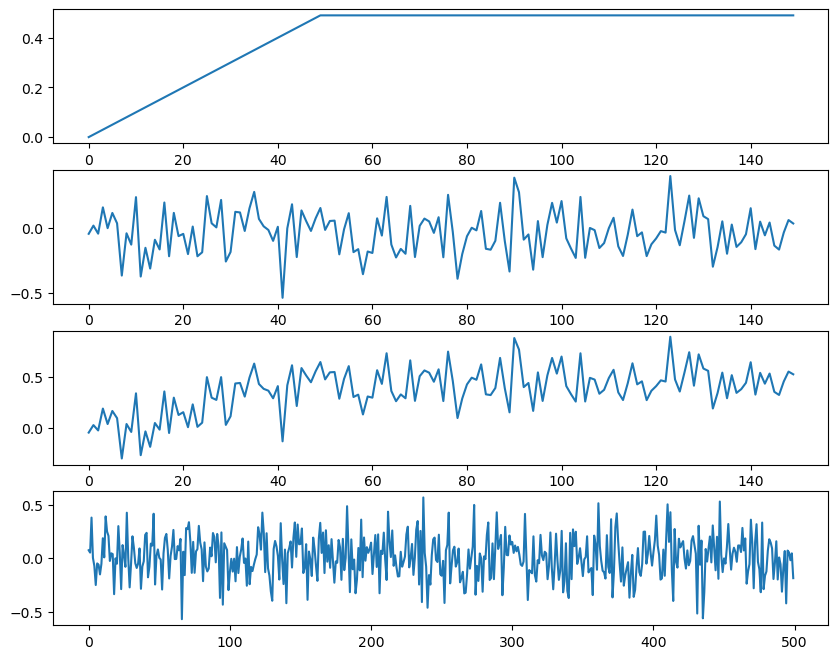

In [6]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
ax1.plot(linear_trend)
ax2.plot(random_noise)
ax4.plot(pi_control)
ax3.plot(time_series)

In [7]:
# Create a cftime range starting at year 0 for 100 years with yearly frequency
time = xr.cftime_range(start=cftime.datetime(1,1,1,0,0,0), periods=len(time_series), freq='YS')
pitime = xr.cftime_range(start=cftime.datetime(1,1,1,0,0,0), periods=len(pi_control), freq='YS')

# Create the DataArray
da = xr.DataArray(
    time_series,
    coords={
        "time": time
    },
    dims="time",
    name="tas"
)

pi_da = xr.DataArray(
    pi_control,
    coords={
        "time": pitime
    },
    dims="time",
    name="tas"
)

In [8]:
da

<xarray.DataArray 'tas' (time: 150)> Size: 1kB
-0.04455 0.02893 -0.02342 0.1903 0.03924 ... 0.354 0.3233 0.4555 0.552 0.5254
Coordinates:
  * time     (time) object 1kB 0001-01-01 00:00:00 ... 0150-01-01 00:00:00

In [9]:
da_trend =  my_stats.trend_fit(da, method='polynomial', order=4)
da_detrend = da - da_trend

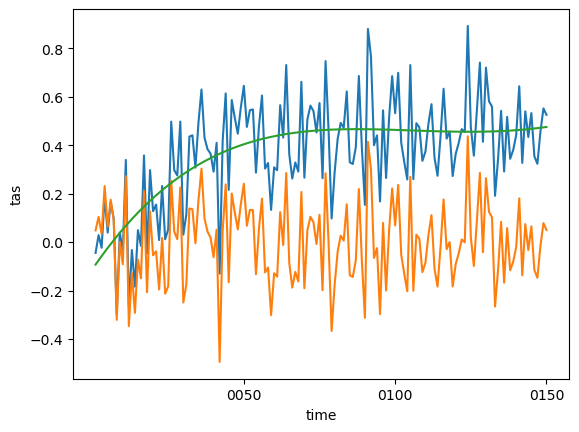

In [10]:
da.plot()
da_detrend.plot()
da_trend.plot()

In [11]:
windows = np.arange(**constants.ZECMIP_MULTI_WINDOW_PARAMS)
windows

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40])

In [12]:
sn_da = sn_calc.signal_to_noise_ratio_multi_window(
    da, 
    windows,
    detrended_data=da_detrend,
    parallel=False,
    noise_type='static',
    logginglevel='ERROR'
)


In [13]:
sn_pi_da = sn_calc.signal_to_noise_ratio_multi_window(
    pi_da, 
    windows,
    parallel=False,
    noise_type='static',
    logginglevel='ERROR'
)

In [14]:
bounds_ds = sn_calc.upper_and_lower_bounds(sn_pi_da, 5, 95)

In [15]:
# The S/N ratio that is unstable - e.g. the A1 S/N where the pi-control is unstable
unstable_sn_da = sn_da.where(np.logical_or(
    sn_da>bounds_ds.upper_bound, # Greater than upper-bounds
    sn_da<bounds_ds.lower_bound)
                                     ) # Less than lower bound

In [77]:
unstable_fraction_da = xr.apply_ufunc( #xr
    sn_calc.get_percent_non_nan,
    unstable_sn_da,
    unstable_sn_da.window,
    input_core_dims=[['time'], []],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[np.float]
).compute()

In [78]:
unstable_fraction_threshold_da = xr.where(unstable_fraction_da>0.4, 1, 0)

In [79]:
total_stable_year_da = xr.apply_ufunc(
    partial(sn_calc.find_stable_year_unsable_window_sel, windows=unstable_sn_da.window.values),
    unstable_sn_da.squeeze(),
    unstable_fraction_threshold_da.squeeze(),
    input_core_dims=[['window', 'time'], ['time', 'window']], 
    output_core_dims = [[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[np.float64]
).compute()

In [80]:
total_stable_year_da.values.item()

47.0

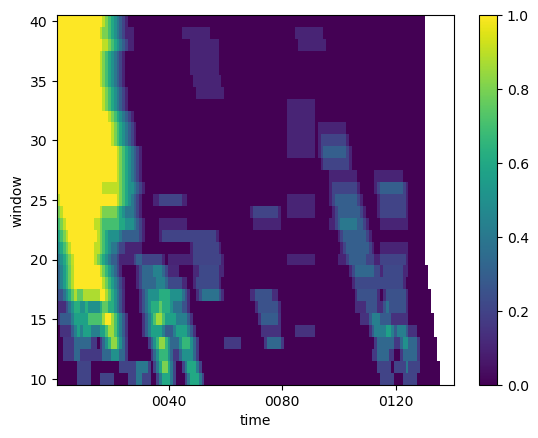

In [27]:
unstable_fraction_da.plot()

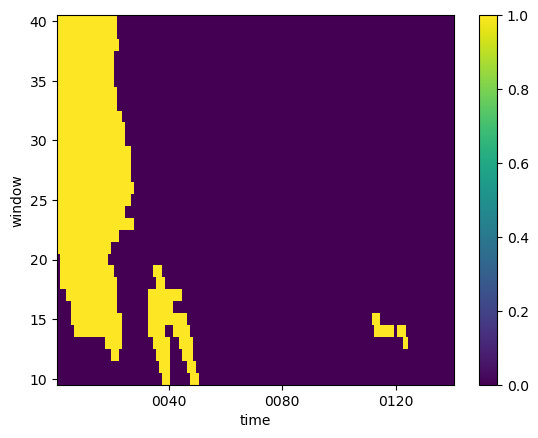

In [31]:
unstable_fraction_threshold_da.plot()

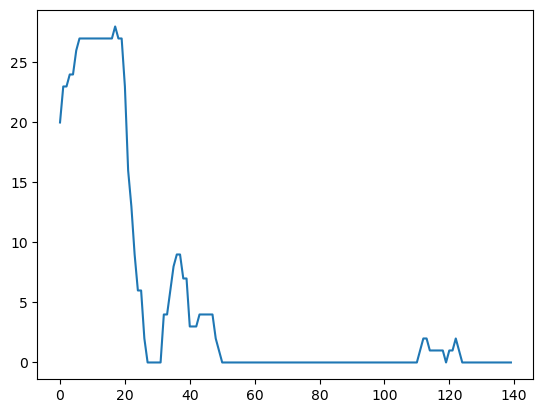

In [51]:
plt.plot(unstable_fraction_threshold_da.sum(dim='window').values)

In [115]:
# # Get the year that stabilisation occurs
# # Note: NOt sure why, but if this isn't done in two parts, this returns a tranpose error.
# year_stable_kwargs = dict(
#     input_core_dims=[['time'], []],
#     output_core_dims=[[]],
#     vectorize=True,
#     dask='parallelized',
#     output_dtypes=[np.float]
# )

# year_stable_all_window_da =xr.apply_ufunc(
#     find_stability_index,
#     unstable_sn_da,
#     unstable_sn_da.window,
#     **year_stable_kwargs
# ).compute()


In [39]:
unstable_sn_da['time'] = unstable_sn_da.time.dt.year.values

In [40]:
trend_length

50

In [42]:
# year_stable_da = year_stable_all_window_da.max(dim='window')
# year_stable_da

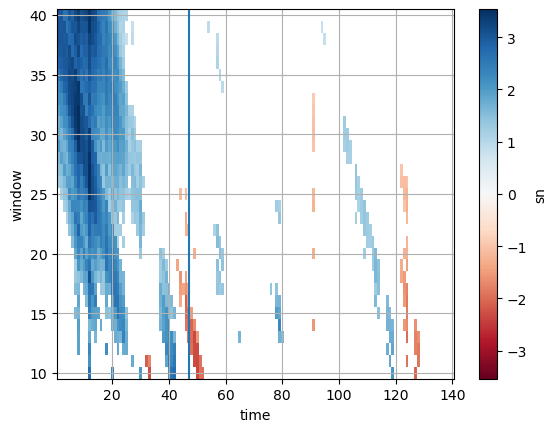

In [49]:
fig, ax = plt.subplots(1, 1)
unstable_sn_da.plot(ax=ax, cmap='RdBu')
# year_stable_all_window_da.plot(y='window')
ax.axvline(total_stable_year_da.values.item())
ax.grid()

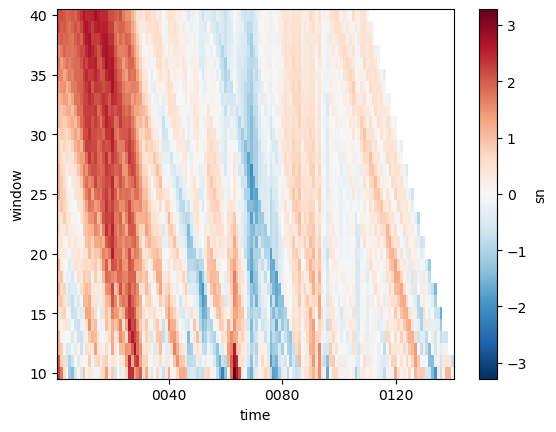

In [120]:
sn_da.plot()

# Distributions

In [52]:
import dask

In [53]:
# client.close()

In [54]:
from dask.distributed import Client
client = Client(memory_limit=None, threads_per_worker=1, n_workers=12)
client

- State start
-   Scheduler at:     tcp://127.0.0.1:38973
-   dashboard at:         /proxy/8787/status
- Registering Worker plugin shuffle
-         Start Nanny at: 'tcp://127.0.0.1:35347'
-         Start Nanny at: 'tcp://127.0.0.1:39415'
-         Start Nanny at: 'tcp://127.0.0.1:38723'
-         Start Nanny at: 'tcp://127.0.0.1:35165'
-         Start Nanny at: 'tcp://127.0.0.1:36431'
-         Start Nanny at: 'tcp://127.0.0.1:37825'
-         Start Nanny at: 'tcp://127.0.0.1:38721'
-         Start Nanny at: 'tcp://127.0.0.1:41123'
-         Start Nanny at: 'tcp://127.0.0.1:43973'
-         Start Nanny at: 'tcp://127.0.0.1:40771'
-         Start Nanny at: 'tcp://127.0.0.1:34217'
-         Start Nanny at: 'tcp://127.0.0.1:45569'
- Register worker <WorkerState 'tcp://127.0.0.1:46287', name: 8, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:46287
- Starting established connection to tcp://127.0.0.1:37188
- Register worker <WorkerState 'tcp://127

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 12
Total threads: 12,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38973,Workers: 12
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:44621,Total threads: 1
Dashboard: /proxy/36445/status,Memory: 0 B
Nanny: tcp://127.0.0.1:35347,


- Register worker <WorkerState 'tcp://127.0.0.1:38869', name: 15, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:38869
- Starting established connection to tcp://127.0.0.1:37614
- Register worker <WorkerState 'tcp://127.0.0.1:36627', name: 14, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:36627
- Starting established connection to tcp://127.0.0.1:37538
- Register worker <WorkerState 'tcp://127.0.0.1:34031', name: 13, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:34031
- Starting established connection to tcp://127.0.0.1:37522
- Register worker <WorkerState 'tcp://127.0.0.1:43371', name: 17, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:43371
- Starting established connection to tcp://127.0.0.1:37684
- Register worker <WorkerState 'tcp://127.0.0.1:36899', name: 12, status: init, memory: 0, processing: 0>
- Starting

In [55]:
client.cluster.scale(30)

-         Start Nanny at: 'tcp://127.0.0.1:46211'
-         Start Nanny at: 'tcp://127.0.0.1:46543'
-         Start Nanny at: 'tcp://127.0.0.1:44617'
-         Start Nanny at: 'tcp://127.0.0.1:36789'
-         Start Nanny at: 'tcp://127.0.0.1:36367'
-         Start Nanny at: 'tcp://127.0.0.1:36131'
-         Start Nanny at: 'tcp://127.0.0.1:33367'
-         Start Nanny at: 'tcp://127.0.0.1:46455'
-         Start Nanny at: 'tcp://127.0.0.1:32991'
-         Start Nanny at: 'tcp://127.0.0.1:43697'
-         Start Nanny at: 'tcp://127.0.0.1:45209'
-         Start Nanny at: 'tcp://127.0.0.1:37447'
-         Start Nanny at: 'tcp://127.0.0.1:38803'
-         Start Nanny at: 'tcp://127.0.0.1:37345'
-         Start Nanny at: 'tcp://127.0.0.1:44893'
-         Start Nanny at: 'tcp://127.0.0.1:36215'
-         Start Nanny at: 'tcp://127.0.0.1:43569'
-         Start Nanny at: 'tcp://127.0.0.1:45261'


In [150]:
def find_stable_year_unsable_window_sel(unstable_pattern_arr, unstable_fraction_arr, windows):
    """
    This function finds the first year in which all windows become stable. It checks when a pattern
    becomes stable across different windows and returns the total year when stability is achieved.

    Parameters:
    ----------
    unstable_pattern_arr : numpy.ndarray
        2D array representing unstable patterns across different windows and years.
    unstable_fraction_arr : numpy.ndarray
        2D array representing the fraction of instability across different windows and years.
        The shape should be the transpose of `unstable_pattern_arr`.

    Returns:
    -------
    int
        The first year in which all windows become stable.

    Raises:
    ------
    AssertionError:
        If the shape of `unstable_pattern_arr` does not match the reversed shape of `unstable_fraction_arr`.
    """
    
    # Ensure that the shapes of the arrays are compatible
    assert unstable_pattern_arr.shape == unstable_fraction_arr.shape[::-1]
    
    # Sum instability across years for each window
    stable_num_arr = np.sum(unstable_fraction_arr, axis=1)

    # Find the first year where all windows are stable (no instability)
    first_year_all_stable = np.where(stable_num_arr == 0)[0][0]

    # If the first year is stable from the start, return this year
    if first_year_all_stable == 0:
        return first_year_all_stable

    # The year before the first fully stable year
    stable_point_query_year = first_year_all_stable - 1

    # Find windows that are unstable in the year before full stability
    windows_that_are_unstable = unstable_fraction_arr[stable_point_query_year, :]

    # Get indices of the unstable windows
    window_unstable_args = np.where(windows_that_are_unstable == 1)[0]

    larst_arg_list = []

    for sarg in window_unstable_args:
        # Select the window size for analysis
        window = windows[sarg]

        # Set the length of the selection window, max of 20 or the window size
        lenght_of_selection = np.min([20, window])

        # Select the analysis window: data from the unstable window at the query year onwards
        # Ensure the dimension order is window first
        anlsysis_window = unstable_pattern_arr[sarg, stable_point_query_year:stable_point_query_year + lenght_of_selection]

        # Find the last stable index (where the data is finite) in the analysis window
        last_arg = sn_calc.get_last_arg_v2(np.isfinite(anlsysis_window))
        larst_arg_list.append(last_arg)

    larst_arg_list = np.array(larst_arg_list)

    # Calculate the maximum extension of stability required across the unstable windows
    stable_year_addition_arg = np.argmax(larst_arg_list)
    stable_year_addition = larst_arg_list[stable_year_addition_arg]
    max_window = windows[window_unstable_args][stable_year_addition_arg]

    # Calculate the total year when stability is achieved
    total_year_stable = first_year_all_stable + stable_year_addition+int(max_window/2)
    
    return total_year_stable

In [151]:
def do_everything(trend_step, trend_length, variance=0.2):
    pi_length = 500
    simulation_length = 100
    linear_trend = np.arange(0, trend_length * trend_step, trend_step)
    linear_trend = np.concatenate([linear_trend, [linear_trend[-1]] * (simulation_length-trend_length)])
    random_noise = np.random.normal(0, variance, len(linear_trend))
    time_series = linear_trend + random_noise
    
    pi_control = np.random.normal(0, variance, pi_length)

    # Create a cftime range starting at year 0 for 100 years with yearly frequency
    time = xr.cftime_range(start=cftime.datetime(1,1,1,0,0,0), periods=len(time_series), freq='YS')
    pitime = xr.cftime_range(start=cftime.datetime(1,1,1,0,0,0), periods=len(pi_control), freq='YS')
    
    # Create the DataArray
    da = xr.DataArray(
        time_series,
        coords={
            "time": time
        },
        dims="time",
        name="tas"
    )
    
    pi_da = xr.DataArray(
        pi_control,
        coords={
            "time": pitime
        },
        dims="time",
        name="tas"
    )
    
    
    da_trend =  my_stats.trend_fit(da, method='polynomial', order=4)
    da_detrend = da - da_trend
    
    sn_da = sn_calc.signal_to_noise_ratio_multi_window(
        da, 
        windows,
        detrended_data=da_detrend,
        parallel=False,
        noise_type='static',
        logginglevel='ERROR'
    )
    sn_pi_da = sn_calc.signal_to_noise_ratio_multi_window(
        pi_da, 
        windows,
        parallel=False,
        noise_type='static',
        logginglevel='ERROR'
    )
    
    bounds_ds = sn_calc.upper_and_lower_bounds(sn_pi_da, 5, 95)
    
    # The S/N ratio that is unstable - e.g. the A1 S/N where the pi-control is unstable
    unstable_sn_da = sn_da.where(np.logical_or(
        sn_da>bounds_ds.upper_bound, # Greater than upper-bounds
        sn_da<bounds_ds.lower_bound)
                                         ) # Less than lower bound
    
    ######### Method 2
    unstable_fraction_da = xr.apply_ufunc( #xr
        sn_calc.get_percent_non_nan,
        unstable_sn_da,
        unstable_sn_da.window,
        input_core_dims=[['time'], []],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[np.float]
    ).compute()
    
    unstable_fraction_threshold_da = xr.where(unstable_fraction_da>0.4, 1, 0)

    # print(unstable_sn_da)
    # print(unstable_fraction_threshold_data)
    total_stable_year_da = xr.apply_ufunc(
        partial(find_stable_year_unsable_window_sel, windows=unstable_sn_da.window.values),
        unstable_sn_da.squeeze(),
        unstable_fraction_threshold_da.squeeze(),
        input_core_dims=[['window', 'time'], ['time', 'window']], 
        output_core_dims = [[]],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[np.float64]
    ).compute()
    
    return total_stable_year_da.values.item()


    ############## Method 1
   # year_stable_kwargs = dict(
   #      input_core_dims=[['time'], []],
   #      output_core_dims=[[]],
   #      vectorize=True,
   #      dask='parallelized',
   #      output_dtypes=[np.float]
   #  )
   #  # year_stable_all_window_da =xr.apply_ufunc(
    #     find_stability_index,
    #     unstable_sn_da,
    #     unstable_sn_da.window,
    #     **year_stable_kwargs
    # ).compute()
    
    
    # year_stable_da = year_stable_all_window_da.max(dim='window')
    # return year_stable_da.values.item()

In [210]:
def run_do_all_heaps(number_runs, variance):
    trend_step_dict = {}
    # np.arange(0.01, 0.11, 0.01)
    for trend_step in np.arange(0.001, 0.001*11, 0.001):
        print(f'\n{trend_step=}\n--------------\n')
        trend_dict = {}
        for trend_length in range(10, 55, 5):
            print(f'{trend_length=}, total_change = {trend_step*trend_length}\n')
            year_list = []
            for i in range(number_runs):
                # print(f'{i}, ', end='')
                year = dask.delayed(do_everything)(trend_step, trend_length, variance=variance)
                # year = do_everything(trend_step, trend_length, variance=variance)
                year_list.append(year)
            year_list = dask.compute(year_list)[0]
            trend_dict[trend_length] = year_list
        trend_step_dict[trend_step] = trend_dict
        # trend_df = pd.DataFrame(trend_dict)
    
    # Flatten the dictionary into a list of tuples
    data = [
        (trend_step, trend_length, year_list)
        for trend_step, trend_dict in trend_step_dict.items()
        for trend_length, year_list in trend_dict.items()
    ]
    
    # Create the DataFrame and set the MultiIndex
    df = pd.DataFrame(data, columns=['trend_step', 'trend_length', 'year_list']).set_index(['trend_step', 'trend_length'])
    
    # Explode the year_list column to create a row for each year
    exploded_df = df.explode('year_list')#.reset_index()

    mean_df = exploded_df.groupby(['trend_step', 'trend_length']).mean() #mean
    mean_df = mean_df.reset_index().pivot_table(
        index='trend_length', columns='trend_step', values='year_list').astype(float)
    mean_df.columns = mean_df.columns.round(4)

    return mean_df

In [201]:
def calculate_error_df(mean_df):
    # Compute the error DataFrame
    error_df = mean_df.copy()
    for index in mean_df.index.values:
        error_df.loc[index] = np.abs((mean_df.loc[index] - index))*100/index
    error_df = error_df.round(0)
    return error_df

In [222]:
# mean_df_0p2 = run_do_all_heaps(200, 0.2)
error_df_0p2 = calculate_error_df(mean_df_0p2)

In [223]:
# mean_df_0p1 = run_do_all_heaps(200, 0.1)
error_df_0p1 = calculate_error_df(mean_df_0p1)

In [224]:
# mean_df_0p4 = run_do_all_heaps(200, 0.4)
error_df_0p4 = calculate_error_df(mean_df_0p4)

In [213]:
mean_df_0p2

trend_step,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.010
trend_length,,,,,,,,,,
10,13.553,12.044,12.704,13.192,13.164,13.400,13.676,13.476,13.304,14.462
15,13.404,13.548,13.675,13.483,14.189,14.364,16.101,16.024,15.822,17.917
20,12.328,13.376,14.632,15.073,15.656,17.097,19.734,20.367,21.857,23.569
25,12.990,13.951,15.797,16.139,19.127,21.175,25.751,25.640,29.041,29.022
30,13.499,14.399,16.075,18.873,21.749,25.468,29.232,31.259,32.913,35.010
35,13.332,15.574,18.460,20.926,27.244,29.385,33.557,36.690,38.238,40.265
40,13.276,16.080,20.348,23.568,27.929,32.379,36.807,39.777,43.130,44.062
45,13.504,15.567,19.528,26.020,30.720,37.140,41.638,44.946,47.620,49.780
50,14.094,16.919,21.083,25.239,30.949,39.630,44.803,48.268,52.997,54.989


In [214]:
# std_df = exploded_df.groupby(['trend_step', 'trend_length']).std()
# std_df = std_df.reset_index().pivot_table(
#     index='trend_length', columns='trend_step', values='year_list').astype(float)
# std_df.columns = std_df.columns.round(4)

In [215]:
# # Compute the error DataFrame
# std_percent_df = std_df.copy()
# for index in std_df.index.values:
#     std_percent_df.loc[index] = std_df.loc[index]*100/index
# std_percent_df = std_percent_df.round(0)

In [216]:
# Compute the total change array
total_change = mean_df_0p2.index.values[:, np.newaxis] * mean_df_0p2.columns.values

# Create a new DataFrame for total change
total_change_df = pd.DataFrame(total_change, index=mean_df.index, columns=mean_df_0p2.columns)
total_change_df

trend_step,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.010
trend_length,,,,,,,,,,
10,0.010,0.02,0.030,0.04,0.050,0.06,0.070,0.08,0.090,0.10
15,0.015,0.03,0.045,0.06,0.075,0.09,0.105,0.12,0.135,0.15
20,0.020,0.04,0.060,0.08,0.100,0.12,0.140,0.16,0.180,0.20
25,0.025,0.05,0.075,0.10,0.125,0.15,0.175,0.20,0.225,0.25
30,0.030,0.06,0.090,0.12,0.150,0.18,0.210,0.24,0.270,0.30
35,0.035,0.07,0.105,0.14,0.175,0.21,0.245,0.28,0.315,0.35
40,0.040,0.08,0.120,0.16,0.200,0.24,0.280,0.32,0.360,0.40
45,0.045,0.09,0.135,0.18,0.225,0.27,0.315,0.36,0.405,0.45
50,0.050,0.10,0.150,0.20,0.250,0.30,0.350,0.40,0.450,0.50


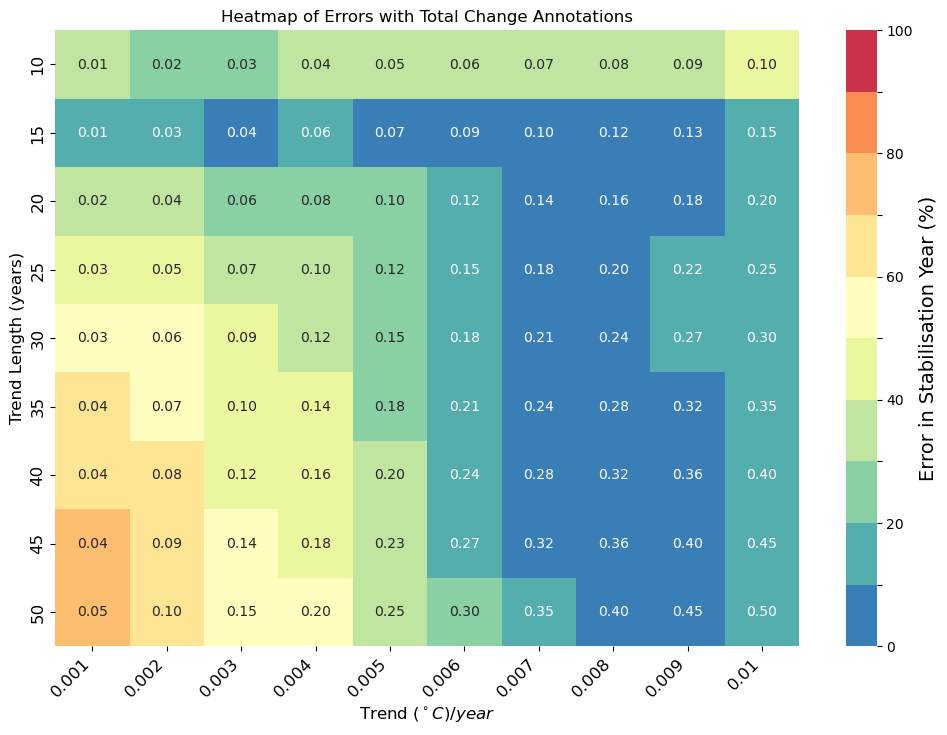

In [217]:

# Define your levels and colors
levels = np.arange(0, 110, 10)
colors = sns.color_palette('Spectral_r', n_colors=len(levels))  # Generate a color palette

# Create a discrete colormap
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=len(levels))

# Plot heatmap of errors with annotations showing total change
fig, ax = plt.subplots(figsize=(12, 8))

# Plot heatmap with colors corresponding to the errors
heatmap = sns.heatmap(error_df_0p2, cmap=cmap, norm=norm, annot=total_change_df, fmt=".2f", ax=ax)
                      # cbar_kws={'label': })

# Customize color bar
cbar = heatmap.collections[0].colorbar
cbar.set_ticks(levels)  # Set ticks on the color bar
 # Replace every second label with ''
cbar.set_ticklabels([f'{level}' if idx % 2 == 0 else '' for idx, level in enumerate(levels)]) 
cbar.set_label('Error in Stabilisation Year (%)', fontsize=14)  # Set the title and adjust font size


ax.set_xticklabels(error_df.columns.round(4));

# Set plot titles and labels
ax.set_title('Heatmap of Errors with Total Change Annotations')
ax.set_xlabel(r'Trend ($^\circ C) / year$', fontsize=12)
ax.set_ylabel('Trend Length (years)', fontsize=12)

# Rotate and resize x-axis tick labels
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12);

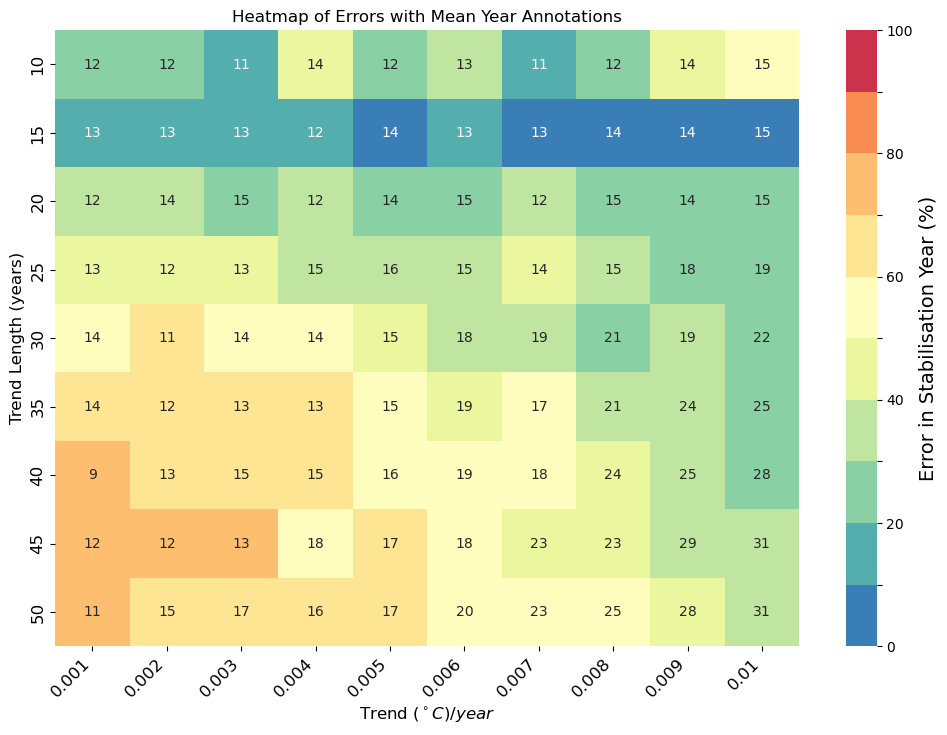

In [225]:

# Define your levels and colors
levels = np.arange(0, 110, 10)
colors = sns.color_palette('Spectral_r', n_colors=len(levels))  # Generate a color palette

# Create a discrete colormap
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=len(levels))

# Plot heatmap of errors with annotations showing total change
fig, ax = plt.subplots(figsize=(12, 8))

# Plot heatmap with colors corresponding to the errors
heatmap = sns.heatmap(error_df_0p4, cmap=cmap, norm=norm, annot=mean_df_0p4.astype(float).astype(int),
                      fmt=".0f", ax=ax)
                      # cbar_kws={'label': })

# Customize color bar
cbar = heatmap.collections[0].colorbar
cbar.set_ticks(levels)  # Set ticks on the color bar
 # Replace every second label with ''
cbar.set_ticklabels([f'{level}' if idx % 2 == 0 else '' for idx, level in enumerate(levels)]) 
cbar.set_label('Error in Stabilisation Year (%)', fontsize=14)  # Set the title and adjust font size


ax.set_xticklabels(error_df.columns.round(4));

# Set plot titles and labels
ax.set_title('Heatmap of Errors with Mean Year Annotations')
ax.set_xlabel(r'Trend ($^\circ C) / year$', fontsize=12)
ax.set_ylabel('Trend Length (years)', fontsize=12)

# Rotate and resize x-axis tick labels
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12);

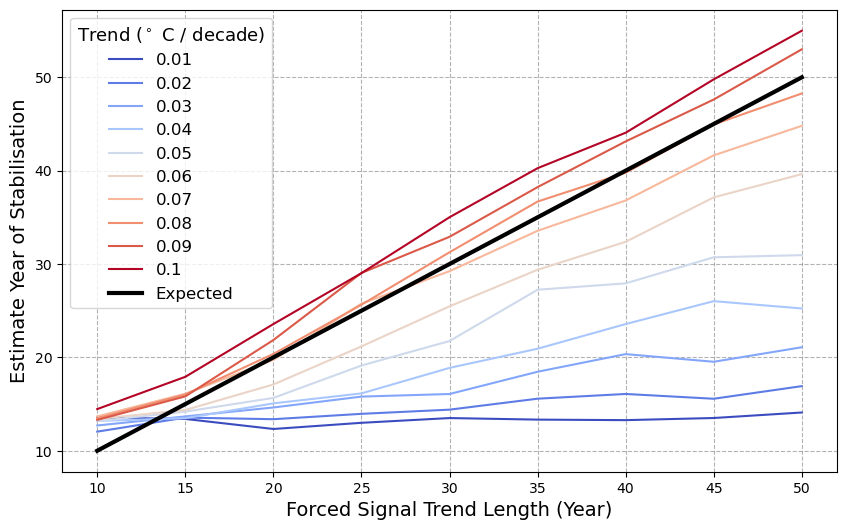

In [233]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(figsize=(10, 6))
expected = np.arange(10, 51, 1)
# Define colormap
cmap = cm.get_cmap('coolwarm', len(mean_df.columns))

# Plot each line with different colors from the colormap
for i, column in enumerate(mean_df_0p2.columns):
    ax.plot(mean_df_0p2.index, mean_df_0p2[column], color=cmap(i / len(mean_df_0p2.columns)), label=column*10)

# for i, column in enumerate(mean_df_0p1.columns):
#     ax.plot(mean_df_0p1.index, mean_df_0p1[column], color=cmap(i / len(mean_df_0p1.columns)),# label=column,
#             linestyle='dotted')

# for i, column in enumerate(mean_df_0p4.columns):
#     ax.plot(mean_df_0p4.index, mean_df_0p4[column], color=cmap(i / len(mean_df_0p4.columns)), #label=column, 
#             linestyle='--')

# Add expected line
ax.plot(expected, expected, color='k', label='Expected', linewidth=3)
ax.legend(title='Trend ($^\circ$ C / decade)', title_fontsize='13', fontsize='12')

# Create custom legend handles for linestyles
# solid_line = mlines.Line2D([], [], color='black', linestyle='-', label='Variance = 0.2')
# dotted_line = mlines.Line2D([], [], color='black', linestyle=':', label='Variance = 0.1')
# dashed_line = mlines.Line2D([], [], color='black', linestyle='--', label='Variance = 0.4')

# Add the custom handles to the legend
# ax.legend(handles=[solid_line, dotted_line, dashed_line], title='Trend ($^\circ C) / year$', title_fontsize=13, fontsize=12)

# Customize labels and title
ax.set_xlabel('Forced Signal Trend Length (Year)', fontsize=14)
ax.set_ylabel('Estimate Year of Stabilisation', fontsize=14)

ax.grid(linestyle='--', color='grey', alpha=0.6)


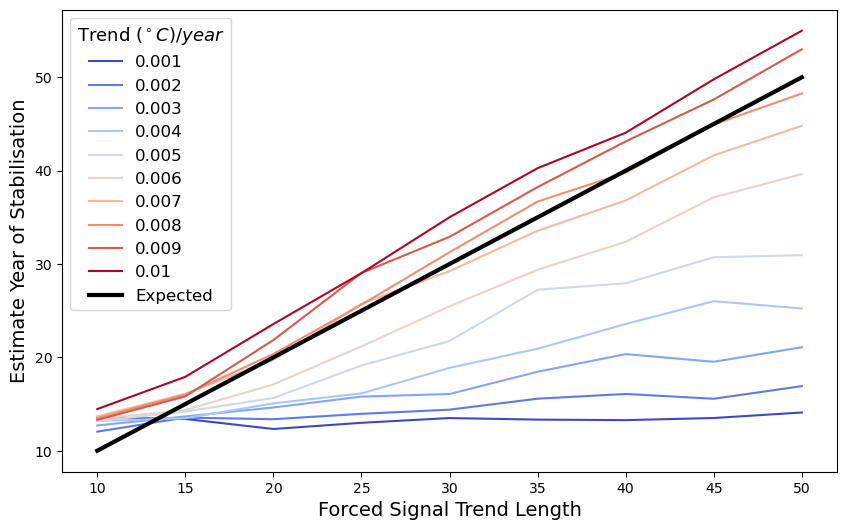

In [207]:
fig, ax = plt.subplots(figsize=(10, 6))
expected = np.arange(10, 51, 1)
# Define colormap
cmap = cm.get_cmap('coolwarm', len(mean_df.columns))

# Plot each line with different colors from the colormap
for i, column in enumerate(mean_df_0p2.columns):
    ax.plot(mean_df_0p2.index, mean_df_0p2[column], color=cmap(i / len(mean_df_0p2.columns)), label=column)

for i, column in enumerate(mean_df_0p1.columns):
    ax.plot(mean_df_0p1.index, mean_df_0p1[column], color=cmap(i / len(mean_df_0p1.columns)), label=column,
           linestyle='dotted')

for i, column in enumerate(mean_df_0p4.columns):
    ax.plot(mean_df_0p4.index, mean_df_0p4[column], color=cmap(i / len(mean_df_0p4.columns)), label=column, 
           line_style='--')

# Add expected line
ax.plot(expected, expected, color='k', label='Expected', linewidth=3)

# Customize labels and title
ax.set_xlabel('Forced Signal Trend Length (Years)', fontsize=14)
ax.set_ylabel('Estimate Year of Stabilisation', fontsize=14)

ax.legend(title='Trend ($^\circ C) / year$', title_fontsize='13', fontsize='12')
ax.grid(linestyle='--', color='grey', alpha=0.6)


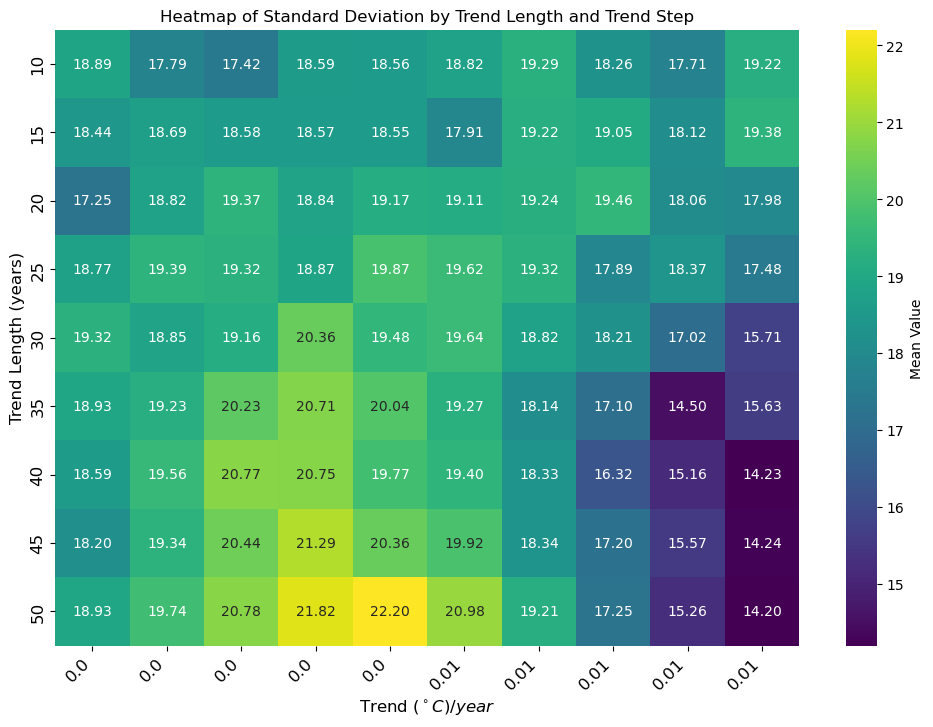

In [188]:
# Plot heatmap
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
sns.heatmap(std_df.astype(float), cmap='viridis', annot=True, fmt=".2f", cbar_kws={'label': 'Mean Value'})
ax.set_title('Heatmap of Standard Deviation by Trend Length and Trend Step')
ax.set_xlabel(r'Trend ($^\circ C) / year$', fontsize=12)
ax.set_ylabel('Trend Length (years)', fontsize=12)
ax.set_xticklabels(error_df.columns.round(2));
# Rotate and resize x-axis tick labels
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate labels by 45 degrees and set font size
plt.yticks(fontsize=12) ;

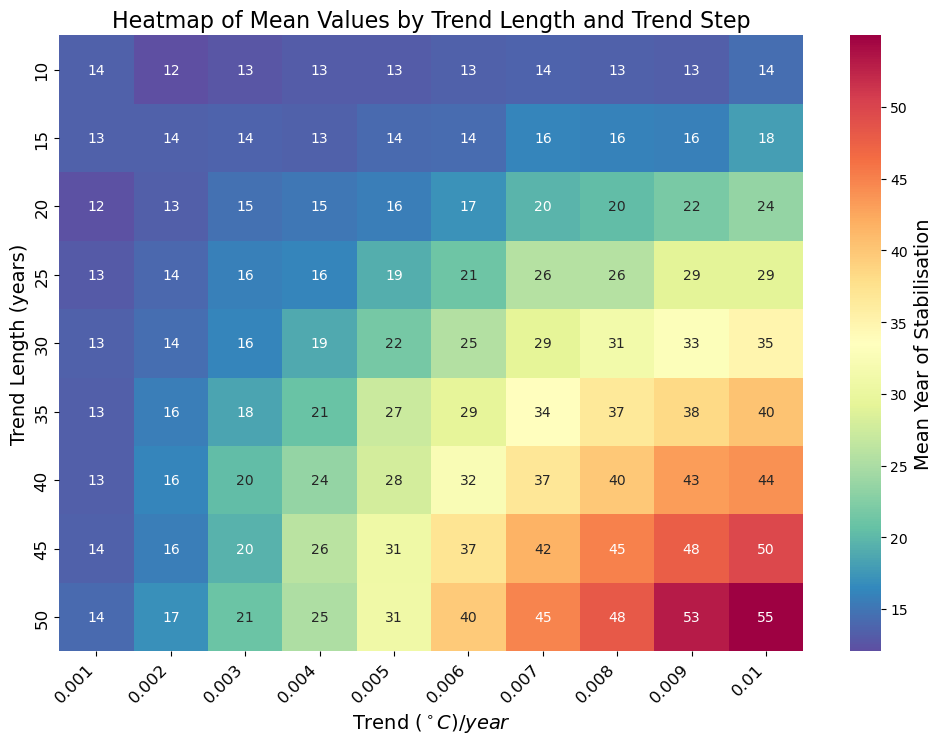

In [190]:

# Plot heatmap
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
heatmap = sns.heatmap(mean_df.astype(float), cmap='Spectral_r', annot=True, fmt=".0f",
                      cbar_kws={'label': 'Mean Value'})

# Access and adjust color bar title
cbar = heatmap.collections[0].colorbar
cbar.set_label('Mean Year of Stabilisation', fontsize=14)  # Set color bar title and adjust font size

# Set plot titles and labels
ax.set_title('Heatmap of Mean Values by Trend Length and Trend Step', fontsize=16)  # Adjust title font size
ax.set_xlabel(r'Trend ($^\circ C) / year$', fontsize=14)
ax.set_ylabel('Trend Length (years)', fontsize=14)
ax.set_xticklabels(mean_df.columns.round(4));

# Rotate and resize x-axis tick labels
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate labels by 45 degrees and set font size
plt.yticks(fontsize=12)

plt.show()


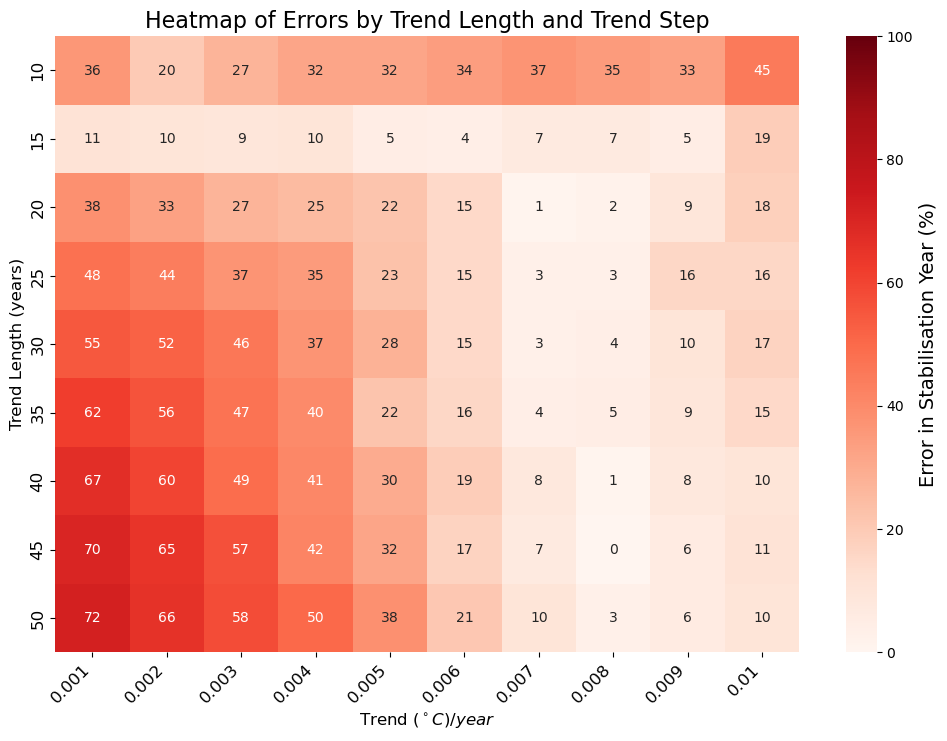

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap of errors
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
heatmap = sns.heatmap(error_df, cmap='Reds', annot=True, vmin=0, vmax=100, cbar_kws={'label': 'Error Value'})

# Access the color bar from the heatmap
cbar = heatmap.collections[0].colorbar
cbar.set_label('Error in Stabilisation Year (%)', fontsize=14)  # Set the title and adjust font size

# Set plot titles and labels
ax.set_title('Heatmap of Errors by Trend Length and Trend Step', fontsize=16)  # Adjust title font size
ax.set_xlabel(r'Trend ($^\circ C) / year$', fontsize=12)
ax.set_ylabel('Trend Length (years)', fontsize=12)
ax.set_xticklabels(error_df.columns.round(4));

# Rotate and resize x-axis tick labels
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate labels by 45 degrees and set font size
plt.yticks(fontsize=12)

plt.show()


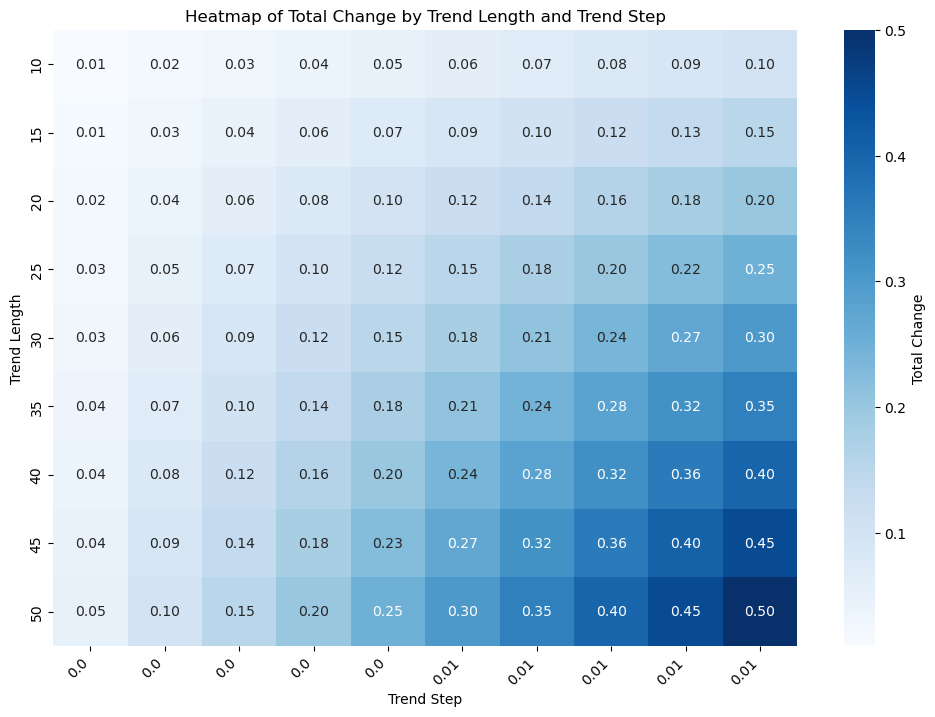

In [185]:

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
sns.heatmap(total_change_df, cmap='Blues', annot=True, fmt=".2f", cbar_kws={'label': 'Total Change'})
ax.set_title('Heatmap of Total Change by Trend Length and Trend Step')
ax.set_xlabel('Trend Step')
ax.set_ylabel('Trend Length')
ax.set_xticklabels(error_df.columns.round(2));

# Rotate and resize x-axis tick labels
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate labels by 45 degrees and set font size
plt.yticks(fontsize=10);

In [194]:
# # Plot heatmap of errors
# fig = plt.figure(figsize=(12, 8))
# ax = fig.add_subplot(111)
# sns.heatmap(std_percent_df, cmap='Reds', annot=True, vmax=100, cbar_kws={'label': 'Error Value'})
# ax.set_title('Heatmap of Errors by Trend Length and Trend Step')
# ax.set_xlabel(r'Trend ($^\circ C) / year$', fontsize=12)
# ax.set_ylabel('Trend Length (years)', fontsize=12)
# # ax.set_xticks(rotation=45)  # Rotate x-axis labels for better readability
# ax.set_xticklabels(std_percent_df.columns.round(2));
# # Rotate and resize x-axis tick labels
# plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate labels by 45 degrees and set font size
# plt.yticks(fontsize=12) ;